In [15]:
import ast
import shap
import optuna
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from utils.myDictionaries import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the default style
pd.set_option('display.max_columns', 100)
pd.set_option('future.no_silent_downcasting', True)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [16]:
df = pd.read_csv('data/carbon_emission.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print('length of the dataframe:', len(df))

df.head()

length of the dataframe: 10000


,body_type,sex,diet,how_often_shower,heating_energy_source,transport,vehicle_type,social_activity,monthly_grocery_bill,frequency_of_traveling_by_air,vehicle_monthly_distance_km,waste_bag_size,waste_bag_weekly_count,how_long_tv_pc_daily_hour,how_many_new_clothes_monthly,how_long_internet_daily_hour,energy_efficiency,recycling,cooking_with,carbonemission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


### Exploration

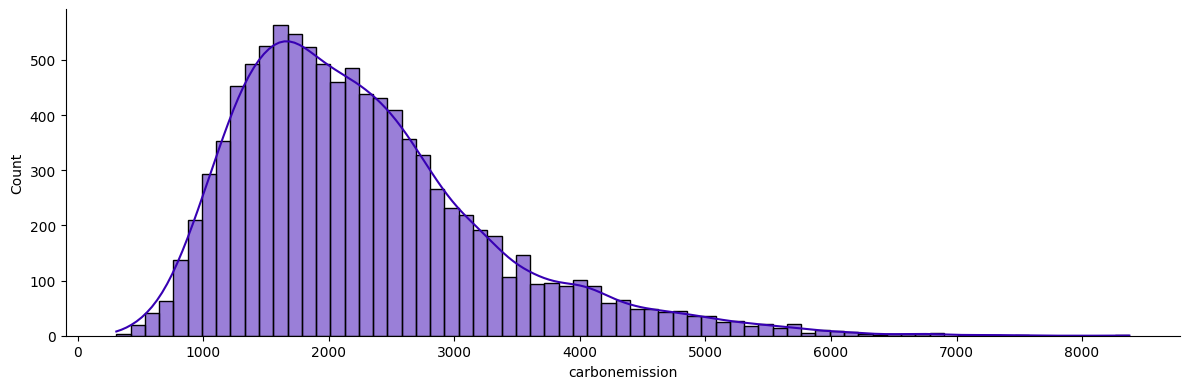

In [17]:
sns.displot(df.carbonemission, kde = True, color = '#3700B3', height = 4, aspect = 3) 
plt.show()

**There are some missing values in Vehicle Type**<br>
Some individuals use bicycle/public transportation, hence the missing values.

In [18]:
df.isna().sum().sort_values(ascending=False).head(3)

vehicle_type      6721
body_type            0
waste_bag_size       0
dtype: int64

In [19]:
df['vehicle_type'] = df['vehicle_type'].fillna('no fuel')

**Converting Categories into Numbers**<br>
If the category's carbon emission is low then it will be replaced with 0.

In [20]:
df['body_type'] = df['body_type'].replace(bodyTypeDict)
df['sex'] = df['sex'].replace(sexDict)
df['diet'] = df['diet'].replace(dietDict)
df['how_often_shower'] = df['how_often_shower'].replace(showerDict)
df['heating_energy_source'] = df['heating_energy_source'].replace(energySourceDict)
df['transport'] = df['transport'].replace(transportDict)
df['vehicle_type'] = df['vehicle_type'].replace(fuelsDict)
df['social_activity'] = df['social_activity'].replace(socialDict)
df['frequency_of_traveling_by_air'] = df['frequency_of_traveling_by_air'].replace(airTravelDict)
df['waste_bag_size'] = df['waste_bag_size'].replace(wasteBagSizeDict)
df['energy_efficiency'] = df['energy_efficiency'].replace(energyEfficiencyDict)
df['recycling'] = df['recycling'].replace("[]", "['no recycling']")

**Correlation** <br>
Correlation between the current features.

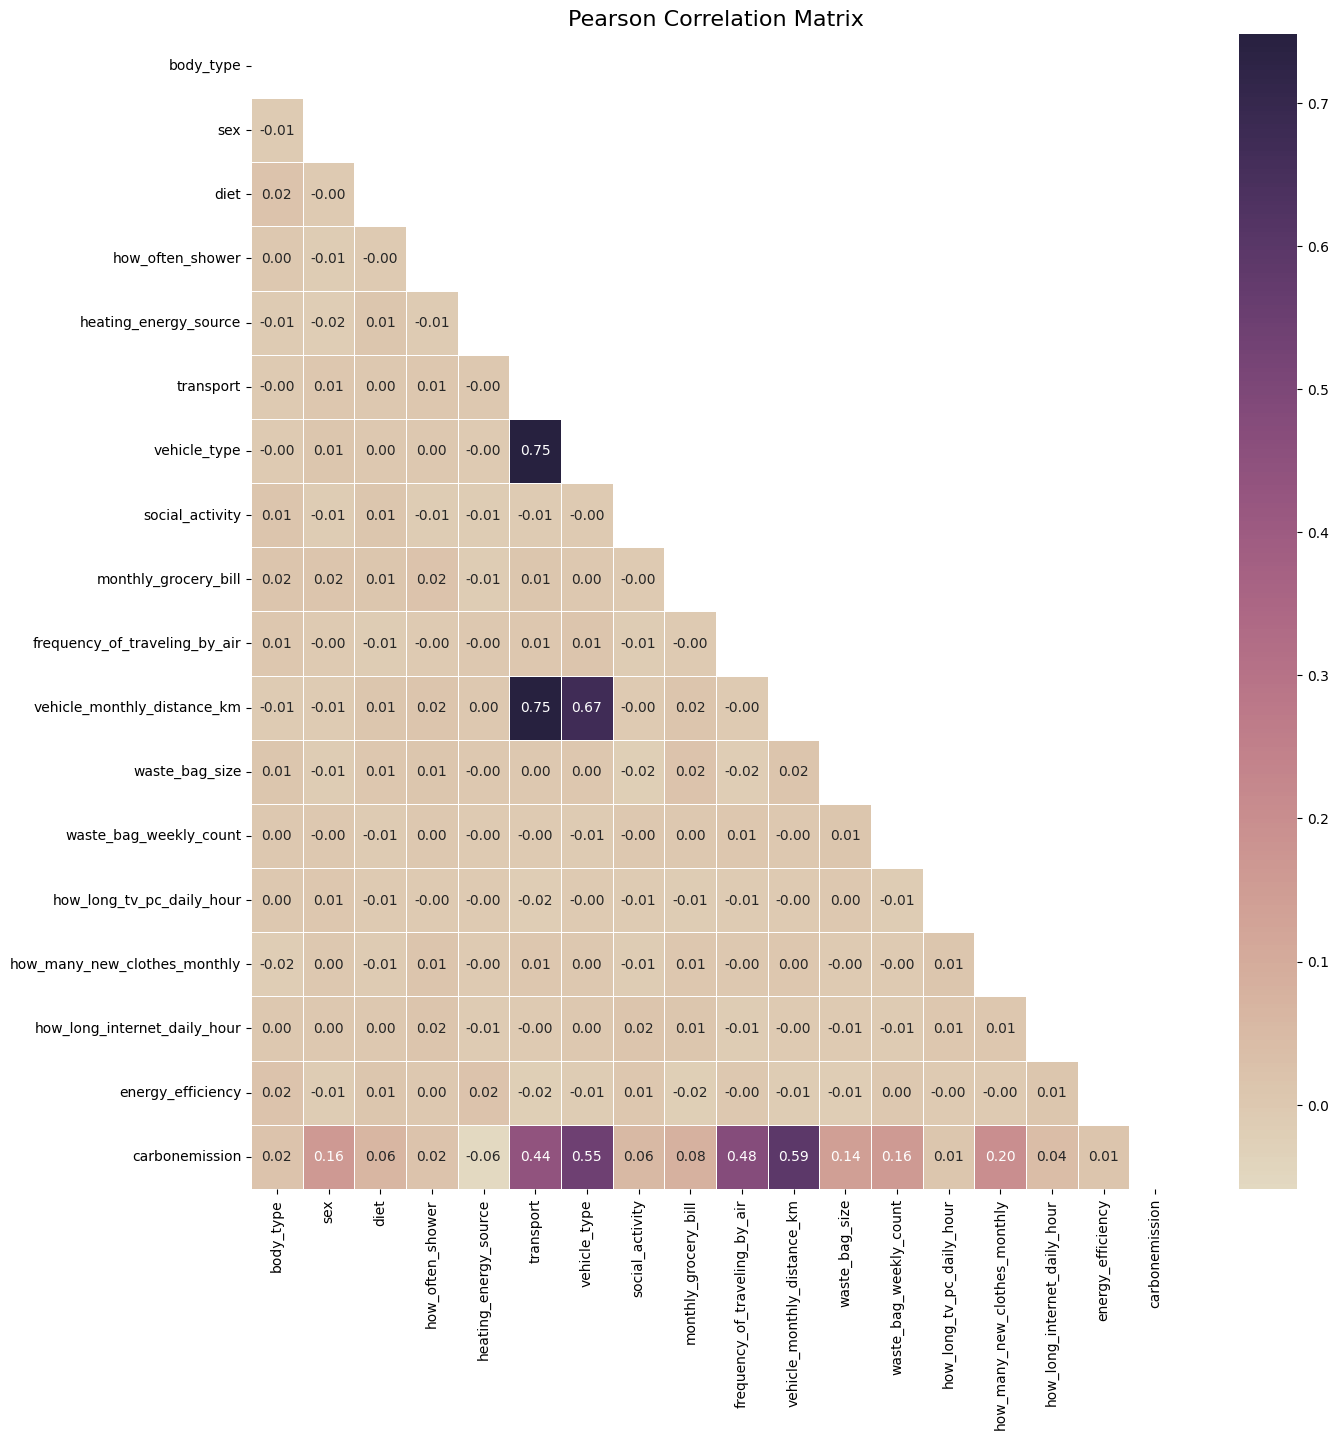

In [21]:
df1 = df.drop(columns=['recycling', 'cooking_with'])
correlation_matrix = df1.corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.yticks(rotation=0)
plt.show()

**Creating new features**

In [22]:
df['wasteBagType'] = df['waste_bag_size'] + df['waste_bag_weekly_count']

**Exploding the list** <br>
There are two columns "recycling" and "cooking_with" which has list. Converting them into one hot.

In [23]:
def process_column(df, column_name):
    df[column_name] = df[column_name].apply(ast.literal_eval)

    df_exploded = df.explode(column_name)
    df_one_hot = pd.get_dummies(df_exploded[column_name]).groupby(df_exploded.index).sum()
    df_one_hot.columns = column_name + "_" + df_one_hot.columns 
    del df[column_name]

    df = df.join(df_one_hot)
    return df

In [24]:
df = process_column(df, 'recycling')
df = process_column(df, 'cooking_with')
del df['cooking_with_Airfryer']

df = df.astype(int)
df.head()

,body_type,sex,diet,how_often_shower,heating_energy_source,transport,vehicle_type,social_activity,monthly_grocery_bill,frequency_of_traveling_by_air,vehicle_monthly_distance_km,waste_bag_size,waste_bag_weekly_count,how_long_tv_pc_daily_hour,how_many_new_clothes_monthly,how_long_internet_daily_hour,energy_efficiency,carbonemission,wasteBagType,recycling_Glass,recycling_Metal,recycling_Paper,recycling_Plastic,recycling_no recycling,cooking_with_Grill,cooking_with_Microwave,cooking_with_Oven,cooking_with_Stove
0,2,0,2,1,2,1,0,2,230,2,210,2,4,7,26,1,2,2238,6,0,1,0,0,0,0,0,1,1
1,1,0,1,0,1,0,0,2,114,1,9,3,3,9,38,5,2,1892,6,0,1,0,0,0,0,1,0,1
2,2,1,3,3,0,2,4,0,138,0,2472,0,1,14,47,6,1,2595,1,0,1,0,0,0,0,1,1,0
3,2,1,3,2,0,0,0,1,157,1,74,1,3,20,5,7,1,1074,4,1,1,1,1,0,1,1,0,0
4,1,0,1,1,2,2,5,2,266,3,8457,2,1,3,5,6,0,4743,3,0,0,1,0,0,0,0,1,0


In [25]:
X = df.drop(columns=['carbonemission'])
y = df['carbonemission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((8000, 27), (2000, 27))

### Modelling

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [28]:
params = {
    'objective': 'reg:squarederror',
    'device': 'cpu',
    'n_jobs': -1,
    'tree_method': 'hist'
}

model = xgb.train(params, dtrain, num_boost_round = 100)
y_pred = model.predict(dtest)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 28293.713416612372
Mean Absolute Error: 120.30036405944824
Root Mean Squared Error: 168.20735244516624
R2 Score: 0.9727868743791656


### Hyperparameter Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)

    params = {
        'objective': 'reg:squarederror',
        'device': 'cpu',
        'n_jobs': -1,
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'lambda': trial.suggest_float('lambda', 0, 10),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = xgb.train(params, dtrain, num_boost_round = 10000, evals = [(dtest, 'test')], early_stopping_rounds = 10, verbose_eval = False)
    y_pred = model.predict(dtest)

    return np.sqrt(mean_squared_error(y_test, y_pred))

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100, show_progress_bar = True)

**Taking best parameters from Optuna**

In [29]:
best_params = {
    'learning_rate': 0.032369048143082876,
    'max_depth': 3,
    'subsample': 0.662497369025867,
    'colsample_bytree': 0.9747623149704492,
    'lambda': 8.604550506264433,
    'alpha': 3.866909145439477,
    'min_child_weight': 6,
    'random_state': 89,
    }

model = xgb.train(
    best_params,
    dtrain,
    num_boost_round = 10000,
    evals=[(dtest, 'test')],
    early_stopping_rounds = 10,
    verbose_eval = False
    )

y_pred = model.predict(dtest)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 10705.267109844466
Mean Absolute Error: 74.49710914611816
Root Mean Squared Error: 103.46626073191428
R2 Score: 0.9897035862922915


In [30]:
joblib.dump(model, 'artifacts/model.joblib')
joblib.dump(scaler, 'artifacts/scaler.joblib')

['artifacts/scaler.joblib']

### SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names = X.columns)